In [1]:
# For the control:
import numpy as np

# For the 3D animation:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 


## Registering the actual joint positions using DH parameters:
Animate a rotation around the base angle to verify that the robot parameters are correct


In [21]:
def T(theta, d, r, alpha):
    cost = np.cos(theta)
    sint = np.sin(theta)
    cosa = np.cos(alpha)
    sina = np.sin(alpha)
    return np.array([[cost, -sint*cosa,  sint*sina, r*cost], 
                     [sint,  cost*cosa, -cost*sina, r*sint],
                     [   0,       sina,       cosa,      d],
                     [   0,          0,          0,      1]])

def pos(T):
    return np.array([T[0,3], T[1,3], T[2, 3]])

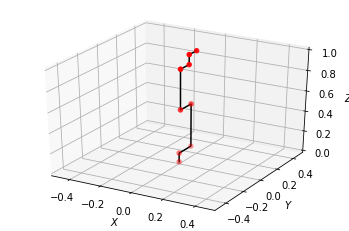

In [23]:
def getCurrentPos(theta_base):
    # Seven joints, because we take the different 'humps' into account.
    Base        = T(theta=theta_base, d=0.089159, r=0.134,    alpha=np.pi/2)
    Shoulder    = T(theta=-np.pi/2,   d=0,        r=-0.425,   alpha=0)
    Elbow       = T(theta=0,          d=0.119,    r=0,        alpha=0)
    ElbowEnd    = T(theta=0,          d=0,        r=-0.39225, alpha=0)
    Wrist1      = T(theta=-np.pi/2,   d=-0.09475, r=0,        alpha=np.pi/2)
    Wrist2      = T(theta=0,          d=0.09475,  r=0,        alpha=-np.pi/2)
    Wrist3      = T(theta=0,          d=-0.0815,  r=0,        alpha=0)
    
    # One necessary rotation - empirically found:
    Base[0,3], Base[1,3] = -Base[1,3], Base[0,3]

    Shoulder    = Base @ Shoulder
    Elbow       = Shoulder @ Elbow
    ElbowEnd    = Elbow @ ElbowEnd
    Wrist1      = ElbowEnd @ Wrist1
    Wrist2      = Wrist1 @ Wrist2
    Wrist3      = Wrist2 @ Wrist3

    BasePos     = pos(Base)
    ShoulderPos = pos(Shoulder)
    ElbowPos    = pos(Elbow)
    ElbowEndPos = pos(ElbowEnd)
    Wrist1Pos   = pos(Wrist1)
    Wrist2Pos   = pos(Wrist2)
    Wrist3Pos   = pos(Wrist3)
    
    X = np.array([0,          0, BasePos[0], ShoulderPos[0], ElbowPos[0], ElbowEndPos[0], Wrist1Pos[0], Wrist2Pos[0], Wrist3Pos[0]])
    Y = np.array([0,          0, BasePos[1], ShoulderPos[1], ElbowPos[1], ElbowEndPos[1], Wrist1Pos[1], Wrist2Pos[1], Wrist3Pos[1]])
    Z = np.array([0, BasePos[2], BasePos[2], ShoulderPos[2], ElbowPos[2], ElbowEndPos[2], Wrist1Pos[2], Wrist2Pos[2], Wrist3Pos[2]])
    return X, Y, Z

def init():
    pass
    
def rotate_base(i):
    theta_base = 2*np.pi/17 * i
    currentPosX, currentPosY, currentPosZ = getCurrentPos(theta_base)
    lines.set_data_3d(currentPosX, currentPosY, currentPosZ)
    balls._offsets3d = (currentPosX, currentPosY, currentPosZ)
    return (lines, balls,)

initPosX, initPosY, initPosZ = getCurrentPos(0)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(0, 1)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')


lines = ax.plot3D(initPosX, initPosY, initPosZ, 'black')[0]
balls = ax.scatter3D(initPosX, initPosY, initPosZ, c='r');

# Don't close original plot to see the robot joints in case animation is not working
# plt.close()

# Call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, rotate_base, frames=35, interval=100, blit=True)

HTML(anim.to_html5_video())

So the coordinate system has positive X and Y in the direction of the frontal left corner, when standing in front of the robot.

## Integrating it into the GUI
What currently exists is:

In [ ]:
# Send message to recived new information
s.send(b"")

# Other information
s.recv(588)

# Position
X  = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
Y  = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
Z  = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
RX = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
RY = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
RZ = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]

What we need to change is this: 

In [ ]:
# Send message to recived new information
s.send(b"")

# Receive angle information - comes before the tool positions:
s.recv(252)

BaseAngle        = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
ShoulderAngle    = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
ElbowAngle       = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
ElbowEndAngle    = ElbowAngle
Wrist1Angle      = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
Wrist2Angle      = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
Wrist3Angle      = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]

SafetyCheckJointPositions([BaseAngle, ShoulderAngle, ElbowAngle, ElbowEndAngle, Wrist1Angle, Wrist2Angle, Wrist3Angle])

# Other information: received 252 + 6*8 bytes = 300 bytes so start from 588 - 300:
s.recv(288)

# Position
X  = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
Y  = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
Z  = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
RX = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
RY = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]
RZ = unpack('!d', bytes.fromhex(str(binascii.hexlify(s.recv(8)).decode("utf-8"))))[0]

In [ ]:
# Somewhere in the same script:
def SafetyCheckJointPositions(angles):
    BaseAngle, ShoulderAngle, ElbowAngle, ElbowEndAngle, Wrist1Angle, Wrist2Angle, Wrist3Angle = angles
    
    # Seven joints, because we take the different 'humps' into account.
    # Ideally this is made once upon starting the robot and updated through the 
    # matrix multiplications below, but I don't know whether that is a good idea,
    # because there are already global parameters, and this function is not part of a class.
    # So if it's fast enough, let's keep it like this.
    Base        = T(theta=BaseAngle,     d=0.089159, r=0.134,    alpha=np.pi/2)
    Shoulder    = T(theta=ShoulderAngle, d=0,        r=-0.425,   alpha=0)
    Elbow       = T(theta=ElbowAngle,    d=0.119,    r=0,        alpha=0)
    ElbowEnd    = T(theta=ElbowEndAngle, d=0,        r=-0.39225, alpha=0)
    Wrist1      = T(theta=Wrist1Angle,   d=-0.09475, r=0,        alpha=np.pi/2)
    Wrist2      = T(theta=Wrist2Angle,   d=0.09475,  r=0,        alpha=-np.pi/2)
    Wrist3      = T(theta=Wrist3Angle,   d=-0.0815,  r=0,        alpha=0)
    
    # One necessary rotation:
    Base[0,3], Base[1,3] = -Base[1,3], Base[0,3]

    Shoulder    = Base @ Shoulder
    Elbow       = Shoulder @ Elbow
    ElbowEnd    = Elbow @ ElbowEnd
    Wrist1      = ElbowEnd @ Wrist1
    Wrist2      = Wrist1 @ Wrist2
    Wrist3      = Wrist2 @ Wrist3

    BasePos     = pos(Base)
    ShoulderPos = pos(Shoulder)
    ElbowPos    = pos(Elbow)
    ElbowEndPos = pos(ElbowEnd)
    Wrist1Pos   = pos(Wrist1)
    Wrist2Pos   = pos(Wrist2)
    Wrist3Pos   = pos(Wrist3)
    
    X = np.array([0,          0, BasePos[0], ShoulderPos[0], ElbowPos[0], ElbowEndPos[0], Wrist1Pos[0], Wrist2Pos[0], Wrist3Pos[0]])
    Y = np.array([0,          0, BasePos[1], ShoulderPos[1], ElbowPos[1], ElbowEndPos[1], Wrist1Pos[1], Wrist2Pos[1], Wrist3Pos[1]])
    Z = np.array([0, BasePos[2], BasePos[2], ShoulderPos[2], ElbowPos[2], ElbowEndPos[2], Wrist1Pos[2], Wrist2Pos[2], Wrist3Pos[2]])
    
    # Check whether box conditions (in meter) are satisfied: 
    # (this is where the limits have to be measured)
    X_lo = -0.2
    X_hi = 0.5
    Y_lo = -0.2
    Y_hi = 0.4
    Z_lo = 0 # of course
    Z_hi = 1.05
    
    # Check X coordinates:
    if not np.all(X_lo < X):
        joint_id = np.where(X_lo > X)[0][0]
        print("Robot joint", joint_id, "out of bounds: smaller than lower X bound")

    if not np.all(X < X_hi):
        joint_id = np.where(X > X_hi)[0][0]
        print("Robot joint", joint_id, "out of bounds: larger than upper X bound")
        
    # Check Y coordinates:
    if not np.all(Y_lo < Y):
        joint_id = np.where(Y_lo > X)[0][0]
        print("Robot joint", joint_id, "out of bounds: smaller than lower Y bound")

    if not np.all(Y < Y_hi):
        joint_id = np.where(Y > Y_hi)[0][0]
        print("Robot joint", joint_id, "out of bounds: larger than upper Y bound")
        
    # Check Z coordinates:
    if not np.all(Z_lo < Z):
        joint_id = np.where(Z_lo > Z)[0][0]
        print("Robot joint", joint_id, "out of bounds: smaller than lower Z bound")

    if not np.all(Z < Z_hi):
        joint_id = np.where(Z > Z_hi)[0][0]
        print("Robot joint", joint_id, "out of bounds: larger than upper Z bound")
        
    # Instead of printing the error I would implement a command to the robot
    # that makes it go back to the beginning:
    
    # position = [item * np.pi / 180 for item in [61.42, -93.0, 94.65, -91.59, -90.0, 0.0]]
    # s.send(b"movej({})".format(position))

    